# Image classification of Scripps plankton camera system images

Use this code as an introduction to using a convolutional neural network (CNN) to classify image data.  The data are images of different categories of plankton from the Scripps plankton camera system. 


1. New users are encouraged to COMMENT (NOT EDIT) the utility functions in CELL 2 as necessary to assist in interpretability for the user.  AGAIN, DO NOT CHANGE THE FUNCTIONS--just comment them if necessary.


2. With the understanding gained from step 1, new users are expected to pre-process the data IN CELL 6. To do so, users must TYPE INTO CELL 6 the functions and their appropriate arguments FROM CELL 2 in the correct order to execute the functions and pre-process the data. 


3. Users should RUN CELL 7 to output some image data and provide some feedback that cell 6 was done correctly.


4. Users are then expected to optimize the CNN by training it. Specifically, the goal is to get the loss (= training loss) and val_loss (= validation loss) as low as possible when training the CNN.  To optimize training, the hyperparameters IN CELL 4 need to be tweaked.  

    New users should ONLY tweak the following parameters and ONLY use the following values in varying combinations:


- `n_conv_layers` using the values 4,5,6,7,8,9,..., or 20. This value is the number of layers
- `n_conv_filters` using ONLY the values 8, 16, 32, 64, or 128. This value is the number of filters
- `kernel size` using ONLY the values (2,2) or (3,3) or (4,4). These values are the kernel sizes

   Any and all combinations of those values should be tested to see which combination gives the lowest losses when executing the next step (step 5.)


5. Using the combination of hyperparameters chosen in cell 4, users then have to train the CNN by RUNNING CELL 8.  Again, the goal is to get the loss and val_loss as low possible. Record somewhere (on a piece of paper, in a git comment, whatever) the hyperparameters for that run, the loss and val_loss at the end of training the CNN, and the the lowest loss/val_loss combination and epoch at which that occured out of all the epochs. 

    A few helpful notes: 
    - The goal is the get the loss to decrease and val_loss to decrease or at least not increase by tweaking hyperparameters
    - Be sure to look at trends for > 20 epochs (i.e., not just the first couple of epochs)
    - If the loss is decreasing and val_loss is increasing, that means the CNN is being overfit
    - For each training run, record 1) the hyperparameters chosen, 2) the loss and val_loss at the end of training, and 3) the lowest loss and val_loss that occured during the entire training run and the epoch at which those lowest values occured.


6. Repeat steps 4 and 5 as necessary to go through any and all combinations of hyperparameters, recording appropriate loss and val_loss and epoch information for each combination. Especially make note of the hyperparameters that give the lowest loss values, as those are the ones that will be used for prediction in the next step.


7. Once the CNN has been trained to optimize the accuracy, the now trained CNN can be used to predict the labels for new image data.  To do so, fill in cell 9 and run it. 


### 1. Importing packages
### Do NOT change anything in this cell 

In [1]:
##########################################################
###### DO NOT CHANGE ANYTHING IN THIS CELL ###############
##########################################################
import glob
import os
import math
from random import shuffle
import time
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Activation, Input, Dense, Conv2D, Dropout, Flatten, BatchNormalization
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard
from keras.utils import np_utils

# The code below are to allow tensorflow to work with Geforce RTX-2070 GPUs
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True  
# to log device placement (on which device the operation ran)                                  
# (nothing gets printed in Jupyter, only if you run it standalone)
config.log_device_placement = True  
sess = tf.Session(config=config)
# set this TensorFlow session as the default session for Keras
set_session(sess)  


Using TensorFlow backend.


### 2. Define utlity and training functions
### Do NOT change anything in this cell , just comment as needed

In [2]:
#######################################################################
######## COMMENT AS NEEDED, BUT DO NOT CHANGE THE FUNCTIONS ###########
#######################################################################

def get_image_files(root_dir, img_types): #defines where to get the images from 
    full_paths = [x for x in os.walk(root_dir)] # put x for every x in root_dir!!home!! within os.walk!!generates the file names in a directory!!
    imgs_temp = [os.path.join(ds,f) for ds,_,fs in full_paths for f in fs if f] #this joins the paths ds,f in full_paths for f in fs only if f is TRUE  
    imgs = [j for j in imgs_temp if any (k in j for k in img_types)] #!!if any() returns True if at least one iterable!!list,string,dictionary,etc!!
    return imgs

def get_dimensions(files): # tells you the dimensions of the files
    min_height, min_width = 10000, 10000
    max_height, max_width = 0, 0
    
    for f in files:
        img = cv.imread(f) # loads an image from files
        h,w = img.shape[:2] # determines shape of an image, h=height w=width, from the beginning up to 2-1
        
        if h < min_height:
            min_height = h 
        if h > max_height:
            max_height = h
        if w < min_width:
            min_width = w
        if w > max_width:
            max_width = w
            
    return min_height, min_width, max_height, max_width

def make_labels(files):
    # Assume input is a list of complete file paths.
    set_temp = {x.split('/')[-2] for x in files} #split files using '/'
    list_temp = list(set_temp) #list of files in set_temp
    list_new = sorted(list_temp) #sorted files in list_temp
    label_dict = {list_new[x]:x for x in range(len(list_new))} 
    
    return label_dict

def make_train_val(files, labels):
    train = []
    valid = []
    train_prop = 0.6 
    for key in labels: 
        temp = [f for f in files if key in f] #
        train.extend(temp[:math.ceil(train_prop*len(temp))])
        valid.extend(temp[math.ceil(train_prop*len(temp)):]) 
    return train, valid

def get_batches(files, label_map, batch_size, resize_size, num_color_channels, augment=False, predict=False):
    shuffle(files)
    count = 0
    num_files = len(files)
    num_classes = len(label_map)

    batch_out = np.zeros((batch_size, resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
    labels_out = np.zeros((batch_size,num_classes)) 

    while True: 

        f = files[count]
        img = cv.imread(f)       

        # Resize
        rows,cols = img.shape[:2] 
        rc_ratio = rows/cols
        if resize_size[0] > int(resize_size[1]*rc_ratio):
            img = cv.resize(img, (resize_size[1], int(resize_size[1]*rc_ratio)))
        else:
            img = cv.resize(img, (int(resize_size[0]/rc_ratio), resize_size[0]))
            
        # Pad
        rows,cols = img.shape[:2] 
        res = np.zeros((resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
        res[(resize_size[0]-rows)//2:(resize_size[0]-rows)//2+rows,
            (resize_size[1]-cols)//2:(resize_size[1]-cols)//2+cols,:] = img 
                
        # Augmentation 
        if augment:            
            rows,cols = res.shape[:2]
            M = cv.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(0.0,360.0,1),1) 
            res = cv.warpAffine(res,M,(cols,rows))

        # Change to gray scale if input argument num_color_channels = 1
        if num_color_channels == 1: 
            res = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
            res = res[...,None] 
            
        batch_out[count%batch_size,...] = res 
        
        for k in label_map.keys():
            if k in f: 
                labels_out[count%batch_size,:] = np_utils.to_categorical(label_map[k],num_classes) 
                break   
                
        count += 1
        if count == num_files:
            count = 0
        if count%batch_size == 0: 
            if predict: 
                yield batch_out.astype(np.float)/255.
            else: 
                yield batch_out.astype(np.float)/255., labels_out
            


### 3. Convolutional neural net classifier class
### Do NOT change anything in this cell 

In [3]:
##########################################################
###### DO NOT CHANGE ANYTHING IN THIS CELL ###############
##########################################################

# Convnet classifier
class classifier():
    def __init__(self,
                 input_shape,
                 n_classes,
                 n_conv_layers=2,
                 n_conv_filters=[32]*2, # individually customizable
                 kernel_size=[(3,2)]*2, # list of integers or tuples
                 n_dense_layers=1,
                 dense_units=[32],
                 dropout=[0.0]*3, # individually customizable
                 strides=[(2,1)]*2,
                 activation='relu',
                 kernel_initializer='glorot_uniform',
                 l1_reg=0.0,
                 lr=0.001
                ):

        if len(n_conv_filters) == 1:
            n_conv_filters = n_conv_filters*n_conv_layers

        if len(kernel_size) == 1:
            kernel_size = kernel_size*n_conv_layers
            
        if len(dense_units) == 1:
            dense_units = dense_units*n_dense_layers

        if len(dropout) == 1:
            dropout = dropout*(n_conv_layers+n_dense_layers)

        if len(strides) == 1:
            strides = strides*n_conv_layers

        self.input_shape=input_shape
        self.n_classes=n_classes
        self.n_conv_layers=n_conv_layers
        self.n_conv_filters=n_conv_filters
        self.kernel_size=kernel_size
        self.n_dense_layers=n_dense_layers
        self.dense_units=dense_units
        self.dropout=dropout
        self.strides=strides
        self.activation=activation
        self.kernel_initializer = kernel_initializer
        self.l1_reg=l1_reg
        self.lr=lr
        self.model = self.get_model()

    def get_model(self):
        I = Input(shape=self.input_shape, name='input')
        X = I
        # Add Conv layers
        for i in range(self.n_conv_layers):
            X = Conv2D(self.n_conv_filters[i], self.kernel_size[i], strides=self.strides[i], padding='same',
                       data_format='channels_last', kernel_initializer=self.kernel_initializer,
                       kernel_regularizer=l1(self.l1_reg), name='conv_{}'.format(i))(X)
            X = Activation(self.activation)(X)
#             X = BatchNormalization()(X)
            X = Dropout(self.dropout[i])(X)
        
        X = Flatten()(X)
        # Add Dense layers
        for i in range(self.n_dense_layers):
            X = Dense(self.dense_units[i], kernel_initializer=self.kernel_initializer,
                      kernel_regularizer=l1(self.l1_reg), name='dense_{}'.format(i))(X)
            X = Activation(self.activation)(X)
#             X = BatchNormalization()(X)
            X = Dropout(self.dropout[i+self.n_conv_layers])(X)
        O = Dense(self.n_classes, activation='softmax', kernel_initializer=self.kernel_initializer,
                  kernel_regularizer=l1(self.l1_reg), name='output')(X)
        
        model = Model(inputs=I, outputs=O)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.lr), metrics=['accuracy'])
        return model


### 4. Training function
### In this cell, tweak only the following parameters:
- `n_conv_layers` using values 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, or 20
- `n_conv_filters` using values 8, 16, 32, 64, or 128
- `kernel_size` using values (2,2), (3,3), or (4,4)

In [4]:
####### CHANGE ONLY PARAMETERS INDICATED BELOW ###########
def train(train_files, val_files, label_map, epochs=100, batch_size=8, common_size=(100,100), num_color_channels=3, 
          new_model=True, save_model_name='classification_model_1.hdf5'):
    num_batches_per_epoch = len(train_files)//batch_size
    
    train_batch_generator = get_batches(train_files, label_map, batch_size, common_size, num_color_channels, augment=True)
    val_batch_generator = get_batches(val_files, label_map, batch_size, common_size, num_color_channels)

    checkpt = ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    if new_model: # create a new model
######### CHANGE THIS SECTION TO CREATE NEW CONVOLUTIONAL ARCHITECTURE #################
        model = classifier([common_size[0], common_size[1], num_color_channels],
                           len(label_map),
                           n_conv_layers=3,#number of convolutional layers
                           n_conv_filters=[16],#number of filters for each conv. layer. Can just put one number to be repeated 
                           kernel_size=[(3,3)],#kernel size for each filter. Can just put one number to be repeated
                           n_dense_layers=2,#number dense layers
                           dense_units=[32],#number of nodes in dense layer. One number gets repeated
                           dropout=[0.0],#proportion of nodes left out of each layer
                           strides=([(1,1)]*2+[(2,2)])*6,#how filter moves across image. Can change stride for each filter. First number is left to right, second is up/down
                           activation='relu',#activation function
                           kernel_initializer='glorot_uniform',#kernel initializer
                           l1_reg=0.0,#l1 norm regularizer
                           lr=0.0001).model #lr = learning rate
    else: # continue to train a previous model
        print('Continuing training from a previous model')
        model = load_model('models/'+save_model_name)

    model.summary()
    model.fit_generator(train_batch_generator, steps_per_epoch=num_batches_per_epoch, epochs=epochs,
                        verbose=1, callbacks=[checkpt, TerminateOnNaN()], 
                        validation_data=val_batch_generator, validation_steps=len(val_files)//batch_size)
    return model

### 5. Prediction function
### Do NOT change anything in this cell

In [5]:
##########################################################
###### DO NOT CHANGE ANYTHING IN THIS CELL ###############
##########################################################

def predict(files, label_map, common_size=(100,100), num_color_channels=3, saved_model_name='classification_model_1.hdf5'):
    model = load_model(saved_model_name)
    num_batches_per_epoch = len(files)    
    predict_batch_generator = get_batches(files, {}, batch_size, common_size, num_color_channels)

    predicts = []
    p = model.predict_generator(predict_batch_generator, steps_per_epoch=num_batches_per_epoch)
    print(p)

### 6. Data preprocessing
#### Fill in the appropriate values and use the appropriate utility functions from cell 2 to pre-process the data 
#### Directions and information are in the comments 

In [6]:
## TO DO: Get full paths to all image classification data and save it in the vairable root_dir
# Data is assumed to reside under the directory "root_dir", and data for each class is assumed to reside in a separate subfolder
# The commmented out line below is an example and won't work on most computers
#root_dir = '/Users/dtaniguchi/Research/Image_classification/Scripps_plankton_camera_system_images/Labeled_images'

## TO DO: Look in the directory of images and determine if any needed extensions need to be added to the list below

root_dir = '/home/guest_3/Desktop/Image_classification_SPCS/Scripps_plankton_camera_system_images/Labeled_ciliates_and_other'
img_types=['.jpg', '.tiff', '.tif', '.png', '.jpeg'] 

# #TO DO: Get the image files and save them in the variable files

files = get_image_files(root_dir, img_types)

print(len(files))
print(files[0:4])

## TO DO: Get the dimension range of the data for informational purposes
# Put min height in variable minh, min width in variable minw, max heigh in variable max h, max width in maxw
min_height, min_width, max_height, max_width = get_dimensions(files)
minh=min_height
minw=min_width
maxh=max_height
maxw=max_width



print('Over all images - minimum height: {}, minimum width: {}, maximum height: {}, maximum width:{}'.format(minh,minw,maxh,maxw))

## TO DO: Assign numerical labels to categories - the number of categories is equal to the number of subfolders
# Put dictionary of categories and numerical labels in the variable label_map

label_map = make_labels(files)

print(label_map)

## TO DO: Split the data into training and validation
# Save training data set in variable train_files and validation data set in val_files

train_files, val_files = make_train_val(files, label_map)

print(len(train_files))
print(len(val_files))

3407
['/home/guest_3/Desktop/Image_classification_SPCS/Scripps_plankton_camera_system_images/Labeled_ciliates_and_other/Ciliate/SPCP2-1522722181-354323-001-1360-2300-120-176.jpg', '/home/guest_3/Desktop/Image_classification_SPCS/Scripps_plankton_camera_system_images/Labeled_ciliates_and_other/Ciliate/SPCP2-1554386146-011363-000-2492-2008-200-120.jpg', '/home/guest_3/Desktop/Image_classification_SPCS/Scripps_plankton_camera_system_images/Labeled_ciliates_and_other/Ciliate/SPCP2-1554390274-043985-001-952-1892-136-104.jpg', '/home/guest_3/Desktop/Image_classification_SPCS/Scripps_plankton_camera_system_images/Labeled_ciliates_and_other/Ciliate/SPCP2-1554375271-025007-001-2448-4-248-152.jpg']
Over all images - minimum height: 24, minimum width: 32, maximum height: 312, maximum width:448
{'Ciliate': 0, 'Other': 1}
2045
1362


### 7. Get batches and test functions run above
#### Run the cell below to get some example data to see if images are processed properly

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


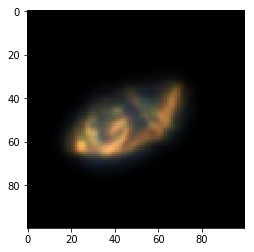

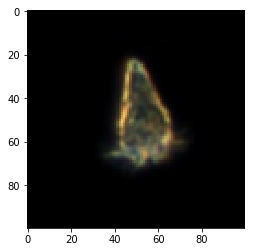

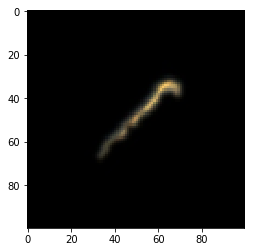

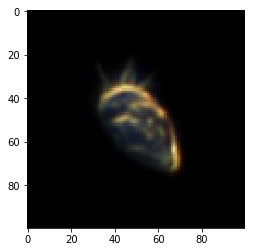

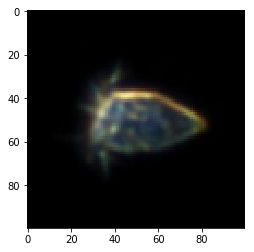

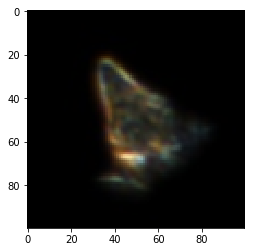

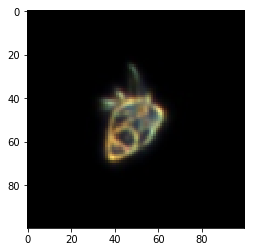

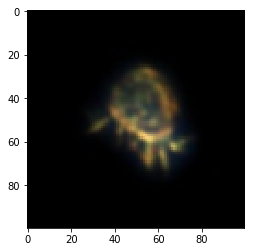

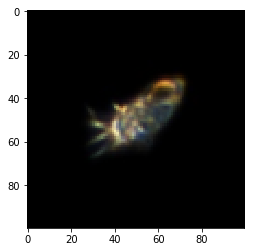

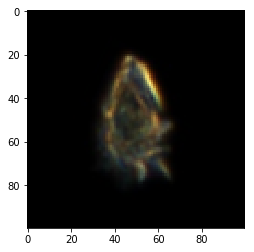

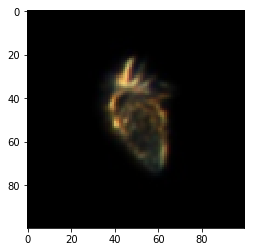

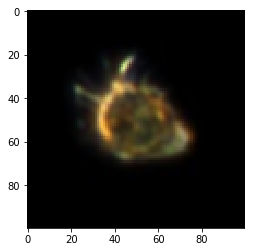

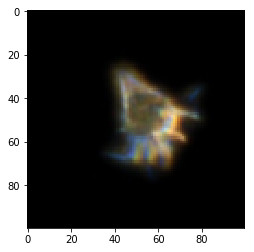

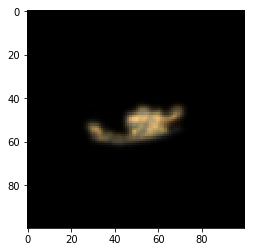

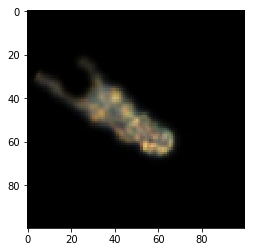

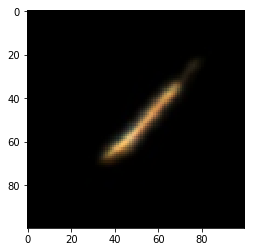

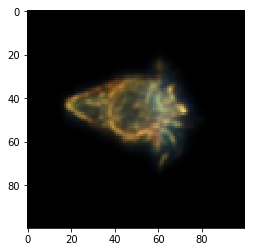

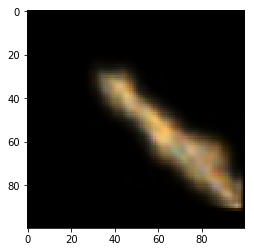

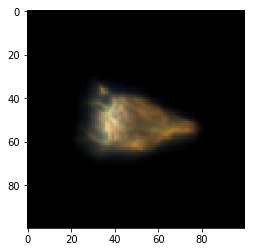

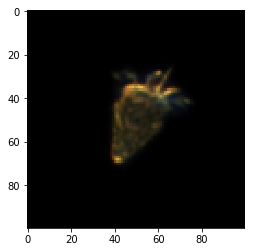

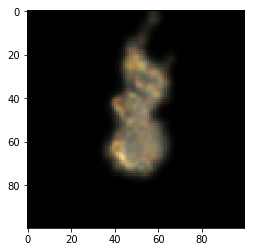

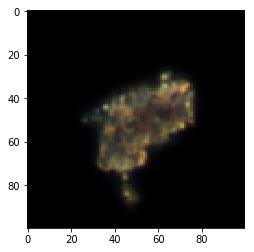

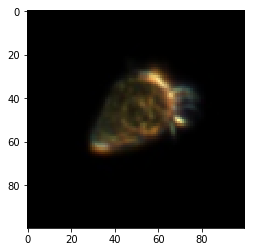

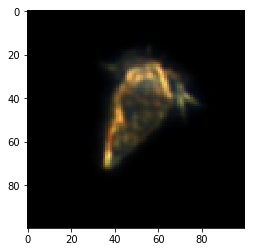

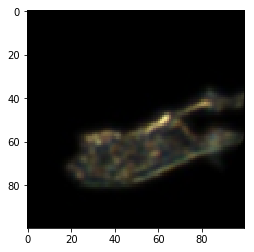

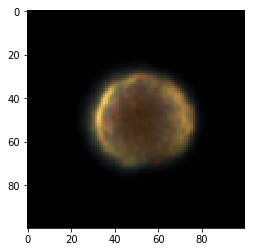

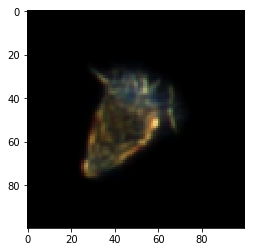

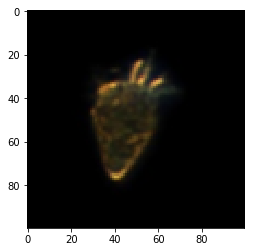

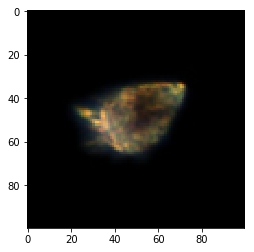

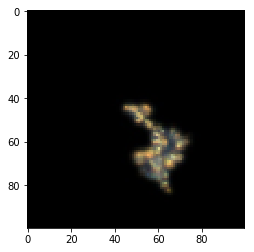

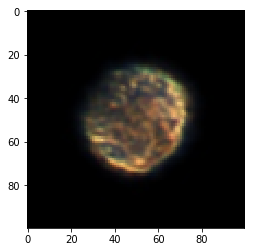

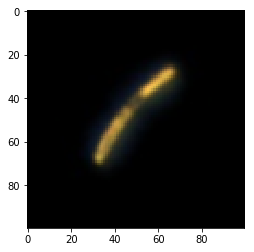

In [7]:
## TO DO: Run this cell to get batches and process some example data
batch_size = 32
common_size = (100,100)
num_color_channels = 3
train_files = train_files[:len(train_files)//batch_size*batch_size]
g = get_batches(train_files, label_map, batch_size, common_size, num_color_channels, augment=True)
b,l = next(g)
for i in b:
    plt.figure()
    plt.imshow(i[...,::-1])


### 8. Training classifier
#### Run the training classifer cell to train the CNN classifer

In [ ]:
# Train a classifier
# Note: all images are resized to common_size.  
# Images smaller than common_size will be enlarged using interpolation.  Images larger will be shrunk using decimation.
batch_size = 32
epochs = 2000
train_files = train_files[:len(train_files)//batch_size*batch_size]
val_files = val_files[:len(val_files)//batch_size*batch_size]
print(len(train_files))
print(len(val_files))
model = train(train_files, val_files, label_map, epochs=epochs, batch_size=batch_size, common_size=(200,200), num_color_channels=3, 
              new_model=True, save_model_name='classification_model_1.hdf5')

W0917 10:08:25.083828 140614756652864 deprecation_wrapper.py:119] From /home/guest_3/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 10:08:25.089073 140614756652864 deprecation_wrapper.py:119] From /home/guest_3/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0917 10:08:25.100664 140614756652864 deprecation_wrapper.py:119] From /home/guest_3/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 10:08:25.154162 140614756652864 deprecation_wrapper.py:119] From /home/guest_3/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0917 10:08:25.1

2016
1344
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 200, 200, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 200, 200, 16)      2320      
_________________________________________________________________
activation_2 (Activation)    (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200, 16)      0         



Epoch 00028: val_loss did not improve from 0.55876
Epoch 29/2000
63/63 [==============================] - 27s 433ms/step - loss: 0.5679 - acc: 0.7450 - val_loss: 0.5630 - val_acc: 0.7485

Epoch 00029: val_loss did not improve from 0.55876
Epoch 30/2000
63/63 [==============================] - 27s 434ms/step - loss: 0.5653 - acc: 0.7475 - val_loss: 0.5603 - val_acc: 0.7507

Epoch 00030: val_loss did not improve from 0.55876
Epoch 31/2000
63/63 [==============================] - 27s 434ms/step - loss: 0.5649 - acc: 0.7470 - val_loss: 0.5623 - val_acc: 0.7493

Epoch 00031: val_loss did not improve from 0.55876
Epoch 32/2000
63/63 [==============================] - 28s 439ms/step - loss: 0.5635 - acc: 0.7485 - val_loss: 0.5619 - val_acc: 0.7493

Epoch 00032: val_loss did not improve from 0.55876
Epoch 33/2000
63/63 [==============================] - 27s 435ms/step - loss: 0.5644 - acc: 0.7480 - val_loss: 0.5618 - val_acc: 0.7493

Epoch 00033: val_loss did not improve from 0.55876
Epoch 34

### 9. Prediction on new data